In [1]:
# Intialization
import os
import sys

os.environ["SPARK_HOME"] = "/home/talentum/spark"
os.environ["PYLIB"] = os.environ["SPARK_HOME"] + "/python/lib"
# In below two lines, use /usr/bin/python2.7 if you want to use Python 2
os.environ["PYSPARK_PYTHON"] = "/usr/bin/python3.6" 
os.environ["PYSPARK_DRIVER_PYTHON"] = "/usr/bin/python3"
sys.path.insert(0, os.environ["PYLIB"] +"/py4j-0.10.7-src.zip")
sys.path.insert(0, os.environ["PYLIB"] +"/pyspark.zip")

# NOTE: Whichever package you want mention here.
# os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.databricks:spark-xml_2.11:0.6.0 pyspark-shell' 
# os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.apache.spark:spark-avro_2.11:2.4.0 pyspark-shell'
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.databricks:spark-xml_2.11:0.6.0,org.apache.spark:spark-avro_2.11:2.4.3 pyspark-shell'

In [2]:
#Entrypoint 2.x
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Spark SQL basic example").enableHiveSupport().getOrCreate()

# On yarn:
# spark = SparkSession.builder.appName("Spark SQL basic example").enableHiveSupport().master("yarn").getOrCreate()
# specify .master("yarn")

sc = spark.sparkContext

Opening the tests dataset

In [4]:
#opening test stock 0
book_test_0=spark.read.parquet('file:///home/talentum/shared/BIGDATAPROYECT/book_test.parquet/stock_id=0/*')
book_test_0.show()

#This is all the data for test, it is clean

+-------+-----------------+----------+----------+----------+----------+---------+---------+---------+---------+
|time_id|seconds_in_bucket|bid_price1|ask_price1|bid_price2|ask_price2|bid_size1|ask_size1|bid_size2|ask_size2|
+-------+-----------------+----------+----------+----------+----------+---------+---------+---------+---------+
|      4|                0| 1.0000491|   1.00059|0.99965584| 1.0006392|       91|      100|      100|       24|
|      4|                1| 1.0000491|   1.00059|0.99965584| 1.0006392|       91|      100|      100|       20|
|      4|                5| 1.0000491| 1.0006392|0.99965584|  1.000885|      290|       20|      101|       15|
+-------+-----------------+----------+----------+----------+----------+---------+---------+---------+---------+



Example of data 0 in the train data

In [5]:
#opening train only dataset 0
book_train_0=spark.read.parquet('file:///home/talentum/shared/BIGDATAPROYECT/book_train.parquet/stock_id=0/c439ef22282f412ba39e9137a3fdabac.parquet')
book_train_0.show(20)
book_train_0.columns
#31a1c5cd6d8546b383d10373db762236.parquet


+-------+-----------------+----------+----------+----------+----------+---------+---------+---------+---------+
|time_id|seconds_in_bucket|bid_price1|ask_price1|bid_price2|ask_price2|bid_size1|ask_size1|bid_size2|ask_size2|
+-------+-----------------+----------+----------+----------+----------+---------+---------+---------+---------+
|      5|                0| 1.0014222| 1.0023013| 1.0013704| 1.0023531|        3|      226|        2|      100|
|      5|                1| 1.0014222| 1.0023013| 1.0013704| 1.0023531|        3|      100|        2|      100|
|      5|                5| 1.0014222| 1.0023013| 1.0013704| 1.0024048|        3|      100|        2|      100|
|      5|                6| 1.0014222| 1.0023013| 1.0013704| 1.0024048|        3|      126|        2|      100|
|      5|                7| 1.0014222| 1.0023013| 1.0013704| 1.0024048|        3|      126|        2|      100|
|      5|               11| 1.0014222| 1.0023013| 1.0013704| 1.0024048|        3|      100|        2|   

['time_id',
 'seconds_in_bucket',
 'bid_price1',
 'ask_price1',
 'bid_price2',
 'ask_price2',
 'bid_size1',
 'ask_size1',
 'bid_size2',
 'ask_size2']

Opening all train data and analizing if is it clean and if present null values.

In [ ]:
#opening all data
mergedDF = spark.read.option("mergeSchema", "true").parquet('file:///home/talentum/shared/BIGDATAPROYECT/book_train.parquet/')


In [ ]:
mergedDF.show(10)
mergedDF.printSchema()



In [ ]:
idi=mergedDF.select('stock_id').distinct().count() 
print(idi)

#Result 112, this is correct! The data is load correct

In [ ]:
dup=mergedDF.groupby(mergedDF.columns).count().where('count > 1')
dup.show()
#there is not dupplicates

In [ ]:
rows=mergedDF.count()
print('number of rows:',rows)
#167253289

In [ ]:
dup2=mergedDF.groupby(['time_id','seconds_in_bucket','stock_id']).count().where('count > 1')
dup2.show()
#there is not dupplicates

Counting null values

In [ ]:
from pyspark.sql.functions import col,isnan, when, count

mergedDF.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in mergedDF.columns]
   ).show()
#There is not null values

# Pre-Data visualization

In [54]:
#Now we plot the diferents caracteristics
#We define important parameters

import numpy as np
from matplotlib import pyplot as plt
from pyspark.sql import functions as F
    
#Defining WAP function
def wap(df,bid_price,ask_price,bid_size,ask_size):
    return (df[bid_price]*df[ask_price]+df[ask_price]*df[bid_size])/(df[bid_size]+df[ask_size])

#I can't convert the pandas funtion to spark
def returns(df,wap):
    data_log=F.log(df[wap])
    data = data_log.withColumn("data", F.col(wap) - F.lag(F.col(wap), 1))


In [55]:
#Ploting wap and logreturns

df=book_train_0

# Add New column with NULL
df=df.withColumn("wap1", wap(df,'bid_price1','ask_price1','bid_size1','ask_size1'))
df=df.withColumn("log_return1", returns(df,'wap1'))

df_pandas = df.toPandas()



TypeError: 'Column' object is not callable

(0.0, 60.0)

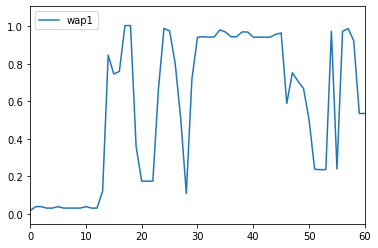

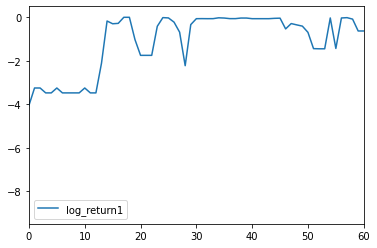

In [39]:
df_pandas.plot.line(y='wap1')
plt.xlim(0,60)

df_pandas.plot.line(y='log_return1')
plt.xlim(0,60)

In [22]:
df.head(1)

[Row(time_id=5, seconds_in_bucket=0, bid_price1=1.0014221668243408, ask_price1=1.0023013353347778, bid_price2=1.0013704299926758, ask_price2=1.0023530721664429, bid_size1=3, ask_size1=226, bid_size2=2, ask_size2=100, wap1=0.017513670775567602)]